# PS.4 (qr-decomposition)

For $A\in\mathbb{R}^{m\times n}$ with $rank(A)=n$, the solution of 

\begin{equation*}
\arg\min_{x\in\mathbb{R}^n} \|Ax - b\|_2.
\end{equation*}

via the qr-decomposition $A=Q R$ is given by

\begin{equation*}
R=\begin{pmatrix}
R_0\\ 0
\end{pmatrix},\qquad \begin{pmatrix}c_0\\c_1\end{pmatrix}=Q^\top b,\qquad R_0 x= c_0.
\end{equation*}

a) Write a function myLLS that takes $A$ as input and returns the solution of the lls problem by calling myQR. 

In [3]:
using LinearAlgebra
function myQR(A)
    m, n = size(A)
    Q = Matrix{Float64}(I,m,m)
    if eltype(A) == ComplexF64 Q = Matrix{ComplexF64}(I,m,m) end
    R = copy(A)
    for k = 1:n
        a = R[k:m,k]
        v = copy(a)
        v[1] += sign(a[1])*norm(a)
        v = v/norm(v)
        Q[k:m,1:m] .= Q[k:m,1:m].-2*v*v'*Q[k:m,1:m]   
        R[k:m,k:n] .= R[k:m,k:n].-2*v*v'*R[k:m,k:n]   
    end
    return Q[1:m,1:m]', triu(R[1:m,1:n])
end

myQR (generic function with 1 method)

In [8]:
function myLLS(A::Matrix,b)
    Q, R = myQR(A)
    c = Q'*b
    return R\c
end

myLLS (generic function with 1 method)

b) Check your implementation by running the testset.

In [9]:
using Test
@testset "myQR" begin   
    m = 200
    n = 100
    ϵ = 1e-13
    for k in 1:10
        A = randn(m,n)+randn(m,n)*1im   # maybe you need to remove the irrational part
        b = randn(m)+randn(m)*1im       # maybe you need to remove the irrational part
        
        Q,R = myQR(A)
        
        @test istriu(R)
        @test norm(Q*Q'-I) < ϵ
        @test norm(Q*R-A)/norm(A) < ϵ

        x = myLLS(A,b)

        @test norm(A'*A*x-A'*b)/norm(A) < ϵ
    end
end

Test Summary: | Pass  Total  Time
myQR          |   40     40  4.2s


Test.DefaultTestSet("myQR", Any[], 40, false, false, true, 1.667827446583644e9, 1.667827450765422e9)

# PS.4 (qr-method for eigenvalues)

Given $A_1:=A$, compute

\begin{align*}
Q_k R_k & = A_k & \text{qr-decomposition of $A_k$}\\
A_{k+1} & = R_k Q_k & \text{recombine factors in reverse order}
\end{align*}

For $k\rightarrow\infty$ and $A$ symmetric and regular, we have

\begin{equation*}
A_k\rightarrow \begin{pmatrix}
\lambda_1\\
& \ddots \\
&&\lambda_n
\end{pmatrix},\qquad Q_1Q_2\cdots Q_k \rightarrow V=(v_1,\ldots,v_n),\qquad A v_j = \lambda_j v_j.
\end{equation*}

a) Write a julia function that computes eigenvalues and eigenvectors via the qr-algorithm.

In [30]:
using LinearAlgebra
function myEigs(A0;tol = 1e-5,maxiter = 1000)  # A0 symmetric
    A = copy(A0)
    local Q
    local R
    V = I
    for k in 1:maxiter
        Q, R = myQR(A)
        A = R*Q
        V = V*Q
        
        if norm(Q - I)/norm(Q) < tol
            break
        end
    end
    println("iteration limit exceeded")
    return diag(Q*R),V
end

myEigs (generic function with 1 method)

We have

\begin{equation*}
A v_j = \lambda_j v_j,\quad j=1,\ldots,n \quad\Leftrightarrow\quad AV=\left(A v_1,\ldots,A v_n\right) = \left(\lambda_1 v_1,\ldots,\lambda_n v_n\right)=V\begin{pmatrix}\lambda_1\\&\ddots\\ &&\lambda_n\end{pmatrix}
\end{equation*}

b) Check your implementation with the following testset and then determine the eigenvalues and eigenvectors of the matrices $A$ and $B$ given below. Can you determine the exact values?

In [32]:
using Test
@testset "myEigs" begin     
    for n in 2:20
        A = rand(n,n)
        A .= A'+A
        
        λ,V = myEigs(A; tol = 1e-8, maxiter = 100000)
            
        @test norm(A*V-V*diagm(λ)) < cond(A)*1e-5
    
    end
end

iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
iteration limit exceeded
Test Summary: | Pass  Total     Time
myEigs        |   19     19  2m30.7s


Test.DefaultTestSet("myEigs", Any[], 19, false, false, true, 1.667828881099859e9, 1.667829031798995e9)

In [37]:
A = [-4.  0. -4. -3.  4.;0.  3. -4.  0. -4.;-4. -4. -4. -4.  3.;-3.  0. -4. -4.  4.;4. -4.  3.  4. -4.]
eigvals, eigvecs = myEigs(A)
eigvals

iteration limit exceeded


5-element Vector{Float64}:
 -14.999999999999982
   7.000000000000007
  -4.99999999999999
  -0.9999999999999998
   0.9999999999999999

In [38]:
B = [ 2. -3.  4.  0.  0.; -3.  2.  4.  0.  0.; 4.  4.  3.  0.  0.; 0.  0.  0. -4.  4.; 0.  0.  0.  4.  2.]
eigvals, eigvecs = myEigs(B)
eigvals

iteration limit exceeded


5-element Vector{Float64}:
  7.0
  4.999999999999974
 -4.9999999999999964
 -6.000000000000013
  4.000000000000003

# PS.4 (Gershgorin circles)

Consider $A = (a_{ij}) \in \mathbb{C}^{n \times n}$ and
\begin{align}
C:= \bigcup_{i=1}^n C_i,
\qquad
C_i = \Big\{ \xi \in \mathbb{C}: |\xi - a_{ii}| \leq \sum_{\substack{j=1 \\ j \neq i}}^n |a_{ij}| \Big\}.
\end{align}

a) If $\lambda$ is an eigenvalue of $A$, then $\lambda\in C$.

b) Illustrate Part a) for a few matrices of your choice by plotting the circles and the eigenvalues appropriately.

In [41]:
using Plots, LinearAlgebra

function circle(x, y = 0, r = 1; n=100)
    θ = 0:1/n:2π
    Plots.Shape(r*sin.(θ) .+ x, r*cos.(θ) .+ y)
end

function myGershgorin(A)
    n = size(A,1)
    d = diag(A)
    r = sum(abs.(A),dims=2).-abs.(d)
    p = plot(circle(real(d[1]),imag(d[1]),r[1]);fillalpha=0.25,aspect_ratio=1,label="C1")
    for k in 2:n
        plot!(circle(real(d[k]),imag(d[k]),r[k]),fillalpha=0.25,label="C$k")
    end
    λ = eigen(A).values
    scatter!(real.(λ),imag.(λ),label="λ")
    display(p)
end

myGershgorin (generic function with 1 method)

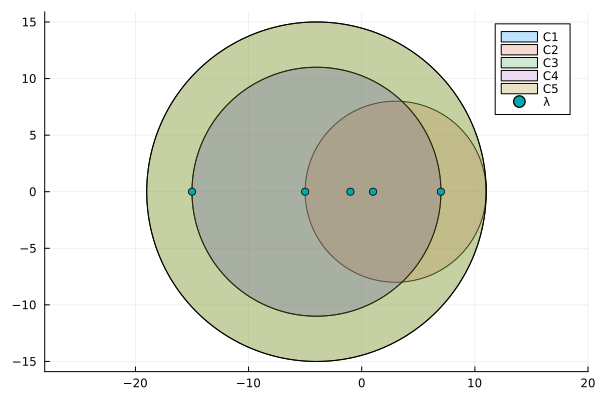

In [42]:
A = [-4.  0. -4. -3.  4.;0.  3. -4.  0. -4.;-4. -4. -4. -4.  3.;-3.  0. -4. -4.  4.;4. -4.  3.  4. -4.]
myGershgorin(A)

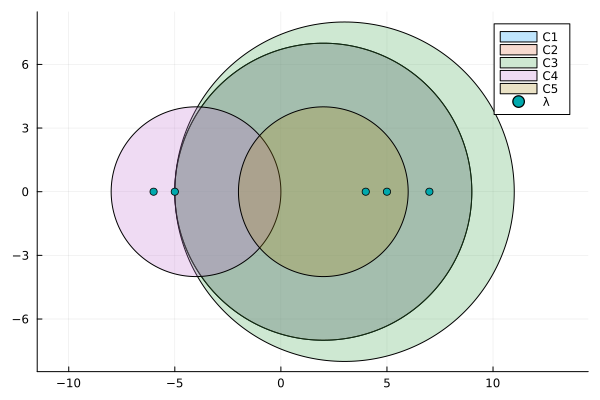

In [43]:
B = [ 2. -3.  4.  0.  0.; -3.  2.  4.  0.  0.; 4.  4.  3.  0.  0.; 0.  0.  0. -4.  4.; 0.  0.  0.  4.  2.]
myGershgorin(B)

# PS.4 (Convergence order)

For fixed $r,s>1$, consider the sequence 
\begin{equation*}
x_k = s^{-r^k}, \qquad k=0,1,2,\ldots
\end{equation*}

a) What is the convergence order of $(x_k)_{k\in\mathbb{N}}$ ?

b) What is the convergence order of $y_k = s^{-k}$, $k=0,1,2,\ldots$ ? Plot $(y_k)_{k\in\mathbb{N}}$, for $s=3,4,5$, in a logarithmic scale.

In [1]:
# using Plots
# n = 100
# k = 0:n
# s = float.([3,4,5])
# plot(s[1].^(-k),yaxis=:log, label="s=3")
# plot!(s[2].^(-k),yaxis=:log, label="s=4")
# ...